In [66]:
import pickle

import librosa.feature
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf

## Define Feature Extraction

Extra feature and statistics ideas from: https://github.com/mdeff/fma/blob/master/features.py

In [67]:
def get_mfcc(y, sr):
    return np.array(librosa.feature.mfcc(y=y, sr=sr))


def get_mel_spectrogram(y, sr):
    return np.array(librosa.feature.melspectrogram(y=y, sr=sr))


def get_chroma_stft(y, sr):
    return np.array(librosa.feature.chroma_stft(y=y, sr=sr))


def get_chroma_cens(y, sr):
    return np.array(librosa.feature.chroma_cens(y=y, sr=sr))

def get_tonnetz(y, sr):
    return np.array(librosa.feature.tonnetz(y=y, sr=sr))


def get_zero_crossing_rate(y):
    return librosa.feature.zero_crossing_rate(y)


def get_spectral_bandwidth(y, sr):
    return librosa.feature.spectral_bandwidth(y=y, sr=sr)


def get_spectral_centroid(y, sr):
    return librosa.feature.spectral_centroid(y=y, sr=sr)


def get_spectral_rolloff(y, sr):
    return librosa.feature.spectral_rolloff(y=y, sr=sr)


def get_spectral_contrast(y, sr):
    return librosa.feature.spectral_contrast(y=y, sr=sr)


def get_poly_features(y, sr):
    return librosa.feature.poly_features(y=y, sr=sr)


def get_tempo(y, sr):
    onset_envelope = librosa.onset.onset_strength(y=y, sr=sr)
    prior_lognorm = stats.lognorm(loc=np.log(120), scale=120, s=1)
    return librosa.feature.tempo(
        onset_envelope=onset_envelope,
        sr=sr,
        aggregate=None,
        prior=prior_lognorm,
    )


def get_feature_stats(values):
    return {
        'mean': np.mean(values, axis=1),
        'std': np.std(values, axis=1),
        'skew': stats.skew(values, axis=1),
        'kurtosis': stats.kurtosis(values, axis=1),
        'median': np.median(values, axis=1),
        'min': np.min(values, axis=1),
        'max': np.max(values, axis=1),
    }


def concatenate_feature_stats(feature_stats):
    return np.concatenate((
        feature_stats['mean'],
        feature_stats['std'],
        feature_stats['skew'],
        feature_stats['kurtosis'],
        feature_stats['median'],
        feature_stats['min'],
        feature_stats['max']
    ))


def get_feature(y, sr):
    mfcc = get_mfcc(y, sr)
    feature_stats = get_feature_stats(mfcc)
    mfcc_feature = concatenate_feature_stats(feature_stats)

    mel_spectrogram = get_mel_spectrogram(y, sr)
    feature_stats = get_feature_stats(mel_spectrogram)
    mel_spectrogram_feature = concatenate_feature_stats(feature_stats)

    chroma_stft = get_chroma_stft(y, sr)
    feature_stats = get_feature_stats(chroma_stft)
    chroma_stft_feature = concatenate_feature_stats(feature_stats)

    chroma_cens = get_chroma_cens(y, sr)
    feature_stats = get_feature_stats(chroma_cens)
    chroma_cens_feature = concatenate_feature_stats(feature_stats)

    tonnetz = get_tonnetz(y, sr)
    feature_stats = get_feature_stats(tonnetz)
    tonnetz_feature = concatenate_feature_stats(feature_stats)

    zero_crossing_rate = get_zero_crossing_rate(y)
    feature_stats = get_feature_stats(zero_crossing_rate)
    zero_crossing_rate_feature = concatenate_feature_stats(feature_stats)

    spectral_bandwidth = get_spectral_bandwidth(y, sr)
    feature_stats = get_feature_stats(spectral_bandwidth)
    spectral_bandwidth_feature = concatenate_feature_stats(feature_stats)

    spectral_rolloff = get_spectral_rolloff(y, sr)
    feature_stats = get_feature_stats(spectral_rolloff)
    spectral_rolloff_feature = concatenate_feature_stats(feature_stats)

    spectral_centroid = get_spectral_centroid(y, sr)
    feature_stats = get_feature_stats(spectral_centroid)
    spectral_centroid_feature = concatenate_feature_stats(feature_stats)

    spectral_contrast = get_spectral_contrast(y, sr)
    feature_stats = get_feature_stats(spectral_contrast)
    spectral_contrast_feature = concatenate_feature_stats(feature_stats)

    poly_features = get_poly_features(y, sr)
    feature_stats = get_feature_stats(poly_features)
    poly_features_feature = concatenate_feature_stats(feature_stats)

    # Note: Tempo takes ages to populate, and doesn't improve the results much, if at all
    # tempo = get_tempo(y, sr)
    # tempo = np.expand_dims(tempo, axis=0)
    # feature_stats = get_feature_stats(tempo)
    # tempo_feature = concatenate_feature_stats(feature_stats)

    return np.concatenate((
        chroma_stft_feature,
        chroma_cens_feature,
        mel_spectrogram_feature,
        mfcc_feature,
        tonnetz_feature,
        zero_crossing_rate_feature,
        spectral_bandwidth_feature,
        spectral_centroid_feature,
        spectral_rolloff_feature,
        spectral_contrast_feature,
        poly_features_feature,
        # tempo_feature,
    ))

## Make Training Data

In [68]:
def make_training_data():
    with open('../pickles/processed_data.pkl', 'rb') as f:
        data = pickle.load(f)
    xs = []
    ys = []
    for label, y, sr in data:
        features = get_feature(y, sr)
        xs.append(features)
        ys.append(label)
    xs = np.array(xs)
    ys = np.array(ys)
    print(xs.shape)
    print(ys.shape)
    permutations = np.random.permutation(999)
    features = np.array(xs)[permutations]
    labels = np.array(ys)[permutations]
    features_train = features[0:900]
    labels_train = labels[0:900]
    features_test = features[900:999]
    labels_test = labels[900:999]
    data_set = (
        (labels_train, features_train),
        (labels_test, features_test)
    )
    with open('data_set.pkl', 'wb') as f:
        pickle.dump(data_set, f)

In [69]:
make_training_data()

(999, 1337)
(999,)


## Define Training Data Loader

In [70]:
def load_data():
    with open('data_set.pkl', 'rb') as f:
        data_set = pickle.load(f)

    return data_set

## Define Build Model, Train and Evaluate Model

In [71]:
def build_model():
    """
    https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
    """

    model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
    model.compile(metrics=["accuracy"])

    return model


def train(model, data_set):
    return model.fit(
        x=data_set[0][1].tolist(),
        y=data_set[0][0].tolist(),
    )


def evaluate_model(model, data_set):
    return model.evaluate(x=data_set[1][1].tolist(), y=data_set[1][0].tolist(), return_dict=True)


## Load Training Data

In [72]:
data_set = load_data()

## Build Model

In [73]:
model = build_model()

Use /var/folders/kr/_kzfl2bd0_b4qw4dj2c4l_x00000gn/T/tmpnlso8m7j as temporary training directory


## Train

In [74]:
history = train(model, data_set)

Reading training dataset...
Training dataset read in 0:00:12.194627. Found 900 examples.
Training model...


[INFO 23-05-18 19:36:01.2202 BST kernel.cc:1242] Loading model from path /var/folders/kr/_kzfl2bd0_b4qw4dj2c4l_x00000gn/T/tmpnlso8m7j/model/ with prefix 55513be4ac8c4a2e


Model trained in 0:00:02.279961
Compiling model...


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

[INFO 23-05-18 19:36:01.5027 BST decision_forest.cc:660] Model loaded with 300 root(s), 56316 node(s), and 1325 input feature(s).
[INFO 23-05-18 19:36:01.5028 BST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-05-18 19:36:01.5033 BST kernel.cc:1074] Use fast generic engine
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model compiled.


## Evaluate

In [75]:
evaluation = evaluate_model(model, data_set)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

4/4 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - accuracy: 0.7475
loss: 0.0000
accuracy: 0.7475


## Plot Accuracy and Loss

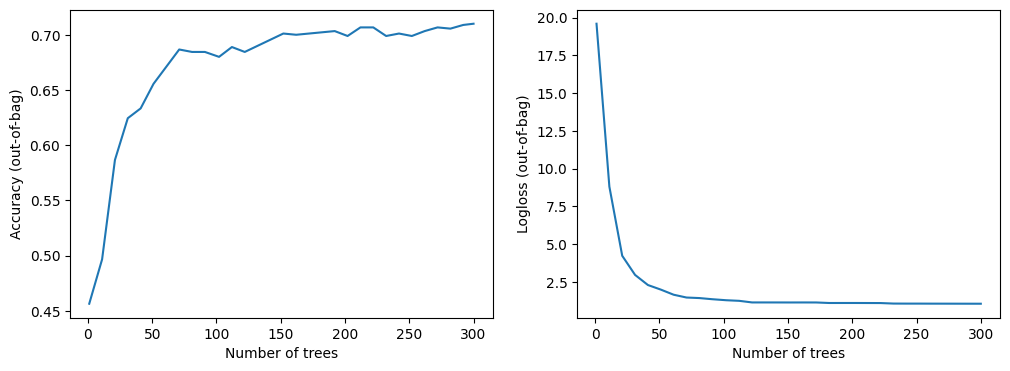

In [76]:
logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

## Save Model

In [77]:
model.save('../saved_models/random_forest_2')

INFO:tensorflow:Assets written to: ../saved_models/random_forest_2/assets


INFO:tensorflow:Assets written to: ../saved_models/random_forest_2/assets
